In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact

In [2]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

# Vert body segmentation

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

In [4]:
root_dir = '/data/PAB_data/vert_seg/'
filename = 'vert_segmenter_preds.npz'

pred_dict = {}
gt_dict = {}
fold_dict = {}
img_dict = {}
for root, dirs, files in os.walk(root_dir):
    if filename in files:
        fold = root.split('/')[-1]
        print(fold)
        pred = np.load(os.path.join(root, filename))
        # Collect targets
        tgt_path = os.path.join(root, 'targets')
        for file in os.listdir(tgt_path):
            name = file.split('.')[0]
            gt_dict[name] = np.load(os.path.join(tgt_path, file))
        # Collect input image
        img_path = os.path.join(root, 'slices')
        for file in os.listdir(img_path):
            name = file.split('.')[0]
            img_dict[name] = np.load(os.path.join(img_path, file))
        # Collect predictions
        for id_, mask in zip(pred['ids'], pred['masks']):
            pred_dict[id_] = mask
            fold_dict[id_] = fold
print(len(pred_dict.keys()), len(list(gt_dict.keys())))

q4
q2
q3
q1
375 375


In [5]:
ids = list(pred_dict.keys())

## Check preds

In [6]:
def plot_pred(name):
    fig, ax = plt.subplots(1, 2, figsize=(20, 40))
    pred = np.argmax(pred_dict[name], axis=0)
    pred = np.where(pred == 0, np.nan, pred)
    ax[0].axis('off')
    ax[1].axis('off')
    gt = gt_dict[name]
    gt = np.where(gt == 0, np.nan, gt)
    ax[0].imshow(img_dict[name], cmap='gray')
    ax[0].imshow(pred, alpha=0.5)
    ax[1].imshow(img_dict[name], cmap='gray')
    ax[1].imshow(gt, alpha=0.5)
    plt.subplots_adjust(wspace=0)

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def multi_class_dsc(pred, gt):
    #pred = [14, H, W]
    dsc_dict = {}
    
    pred_idx = np.unique(pred)
    gt_idx = np.unique(gt)
    pred_idx = np.delete(pred_idx, 0) -1 
    gt_idx = np.delete(gt_idx, 0)-1
    # Convert to one-hot
    gt_hot = np.zeros((13, 13))
    gt_hot[gt_idx, gt_idx] = 1
    
    pred_hot = np.zeros((13, 13))
    pred_hot[pred_idx, pred_idx] = 1
    
    accuracy = pred_hot[gt_hot == 1].sum()/gt_hot[gt_hot==1].sum()
    verts = [ordered_verts[idx] for idx in gt_idx]
    pred_verts = [ordered_verts[idx] for idx in pred_idx]
    for channel in range(14):
        if channel == 0: 
            continue
        vert = ordered_verts[channel-1]
        tmp_pred = np.where(pred == channel, 1, 0)
        tmp_gt = np.where(gt==channel, 1, 0)
        dsc_dict[vert] = np.round(dice_coef(tmp_gt, tmp_pred), 4)
    dsc_df = pd.DataFrame(index=ordered_verts, columns=['Dice', 'GT', 'Pred'])
    
    gt_dict = {}
    for vert in ordered_verts:
        if vert in verts:
            gt_dict[vert] = 1
        else: 
            gt_dict[vert] = 0
    gt_srs = pd.Series(gt_dict)
    
    pred_dict = {}
    for vert in ordered_verts:
        if vert in pred_verts:
            pred_dict[vert] = 1
        else:
            pred_dict[vert] = 0
    pred_srs = pd.Series(pred_dict)
    
    dsc_df['Dice'] = pd.Series(dsc_dict)
    dsc_df['GT'] = gt_srs
    dsc_df['Pred'] = pred_srs
    return dsc_df, accuracy
    
def get_dice(name, plot=False):
    pred = np.argmax(pred_dict[name], axis=0)
    gt = gt_dict[name]
    dsc_df, accuracy = multi_class_dsc(pred, gt)
    if plot:
        plot_pred(name)
    return dsc_df, accuracy

In [8]:
dsc_dict = {vert: [] for vert in ordered_verts}
accuracy = {}
for name in ids:
    dsc = get_dice(name)
    dsc, acc = dsc 
    dice = dsc[(dsc['Pred'] == 1)&(dsc['GT'] == 1)]['Dice']
    for vert, val in dice.iteritems():
        dsc_dict[vert].append(val)
    accuracy[name] = acc
dsc_df = pd.DataFrame.from_dict(dsc_dict, orient='index')
dsc_df.T.head()

,T4,T5,T6,T7,T8,T9,T10,T11,T12,L1,L2,L3,L4
0,0.0000,0.0000,0.0000,0.0000,0.6425,0.8464,0.4774,0.9185,0.9499,0.9516,0.9411,0.9694,0.9827
1,0.0000,0.0000,0.0000,0.8121,0.1941,0.0000,0.8079,0.5733,0.9713,0.8703,0.9458,0.9333,0.9232
2,0.0000,0.0000,0.0496,0.8455,0.6836,0.7990,0.0000,0.0000,0.6584,0.2462,0.6422,0.9622,0.9495
3,0.5263,0.6582,0.3484,0.3787,0.0000,0.8536,0.8761,0.8106,0.0787,0.9607,0.9621,0.9593,0.9571
4,0.2244,0.6702,0.6297,0.8071,0.0000,0.0000,0.4914,0.9539,0.0000,0.0000,0.0000,0.9649,0.9659


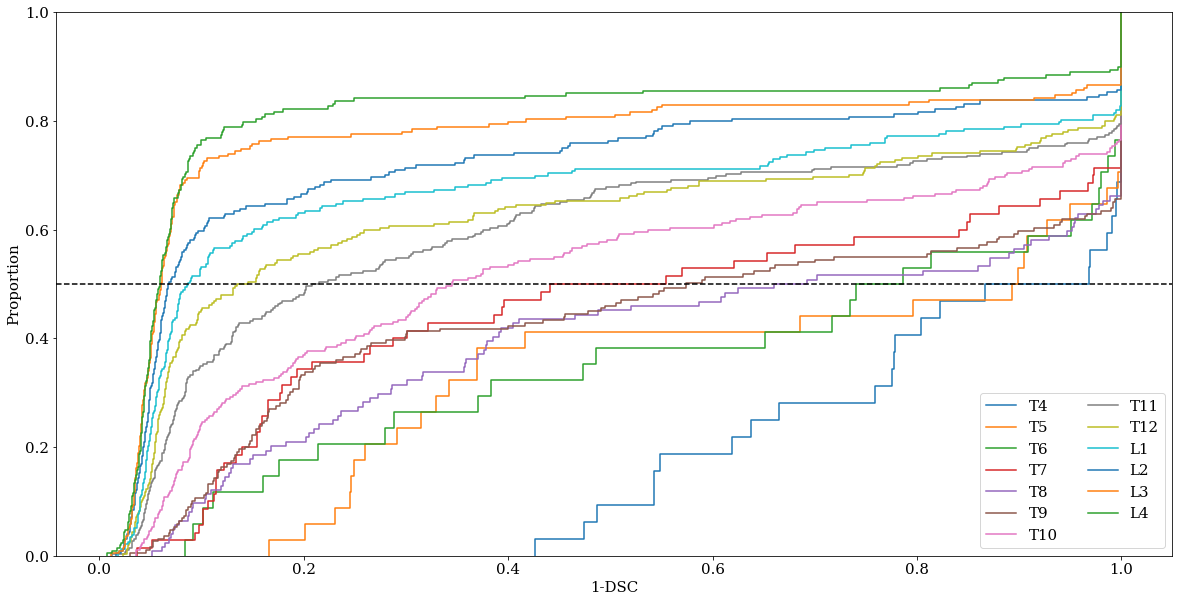

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for vert in dsc_df.index:
    subset = 1-dsc_df.loc[vert].dropna()
    sns.ecdfplot(data=subset, label=vert)
ax.axhline(0.5, c='k', ls='--')
ax.set_xlabel('1-DSC')
plt.legend(ncol=2)

Text(0.5, 0, '1-Accuracy')

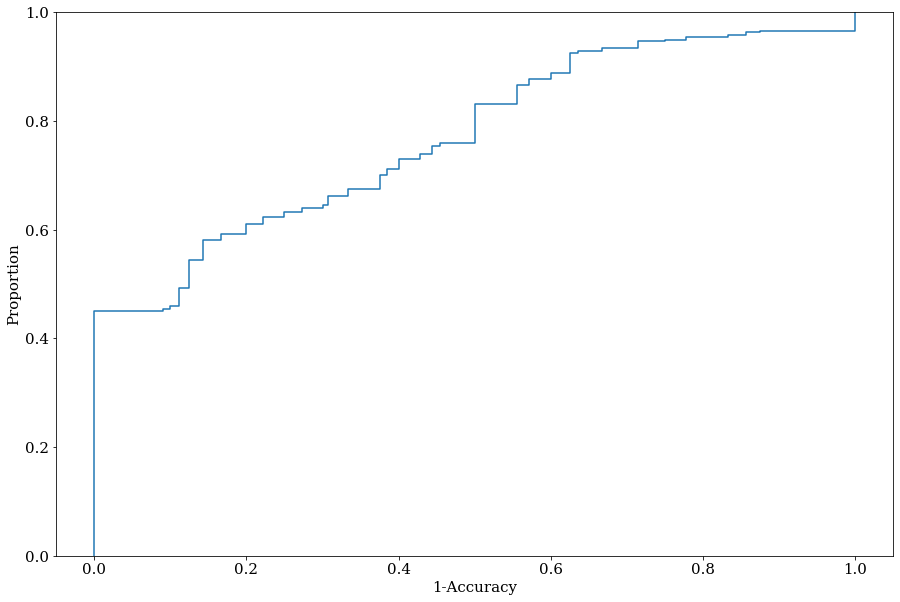

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.ecdfplot(data=1-np.array(list(accuracy.values())))
ax.set_xlabel('1-Accuracy')